# Introduction

In todays world, a user is often faced with multiple choices and often does not have the intrest to browse through the options.



We will look at the concept of Recommendation system using Goodreads book dataset

The goodreads book dataset contains six million ratings for 10000 most popular books.The dataset contains, ratings for the books by users, the books marked to-read by users, metadata of the book and tags associated with abook
Ratings are between 1-5. Both book IDs and user IDs are contiguous. For books, they are 1-10000, for users, 1-53424.



The link to the dataset can be found at :

https://github.com/zygmuntz/goodbooks-10k/releases

## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_colwidth', -1)

import os

In [2]:
input_path="../data/goodbooks-10k/"

In [3]:
os.listdir(input_path)

['book_tags.csv',
 'LICENSE',
 'tags.csv',
 'README.md',
 'ratings.csv',
 'to_read.csv',
 'books.csv']

## The data folder has the following data files

**ratings.csv** contains ratings sorted by time. It is 69MB and looks like that:
user_id,book_id,rating
1,258,5
2,4081,4
2,260,5
2,9296,5
2,2318,3

Ratings go from one to five. Both book IDs and user IDs are contiguous. For books, they are 1-10000, for users, 1-53424. 	

**to_read.csv** provides IDs of the books marked "to read" by each user, as _user_id,book_id_ pairs, sorted by time. There are close to a million pairs.

**books.csv** has metadata for each book (goodreads IDs, authors, title, average rating, etc.).

**book_tags.csv** contains tags/shelves/genres assigned by users to books. Tags in this file are represented by their IDs. They are sorted by _goodreads_book_id_ ascending and _count_ descending. 



## Load the data

In [4]:
ratings=pd.read_csv(input_path+"ratings.csv")
ratings.head()

,user_id,book_id,rating
0,1,258,5
1,2,4081,4
2,2,260,5
3,2,9296,5
4,2,2318,3


In [5]:
to_read=pd.read_csv(input_path+"to_read.csv")
to_read.head()

,user_id,book_id
0,9,8
1,15,398
2,15,275
3,37,7173
4,34,380


In [6]:
books=pd.read_csv(input_path+"books.csv")
books.head()

,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m/2767052.jpg,https://images.gr-assets.com/books/1447303603s/2767052.jpg
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,...,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m/3.jpg,https://images.gr-assets.com/books/1474154022s/3.jpg
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,...,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m/41865.jpg,https://images.gr-assets.com/books/1361039443s/41865.jpg
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,...,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m/2657.jpg,https://images.gr-assets.com/books/1361975680s/2657.jpg
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,...,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m/4671.jpg,https://images.gr-assets.com/books/1490528560s/4671.jpg


In [7]:
book_tags=pd.read_csv(input_path+"book_tags.csv")
book_tags.head()

,goodreads_book_id,tag_id,count
0,1,30574,167697
1,1,11305,37174
2,1,11557,34173
3,1,8717,12986
4,1,33114,12716


In [8]:
tags=pd.read_csv(input_path+"tags.csv")
tags.head()

,tag_id,tag_name
0,0,-
1,1,--1-
2,2,--10-
3,3,--12-
4,4,--122-


### How are we goin to evaluate our recommendation Model?

We have data on what books the users have marked as to read. We can predict top k books for each user and calculate the orecision and recall

## How can we recommend Books to Users?

1. Recommend most popular book among all users - In this method, we lose out on user personalisation
2. Recommend books based on what users with similar reading preference have liked
3. Recommend books similar to what user has liked in the past

## Exploring the data

#### Are there any duplicate (user_id,book_id) pairs??

In [9]:
duplicate=ratings.groupby(['user_id','book_id'])['rating'].count().reset_index().rename(columns={'rating':'#Ratings'})
max(duplicate['#Ratings'])

1

There are no duplicate (user_id,book_id) pairs

#### What is the distribution of Ratings?

Text(0.5,1,'Distribution of Ratings')

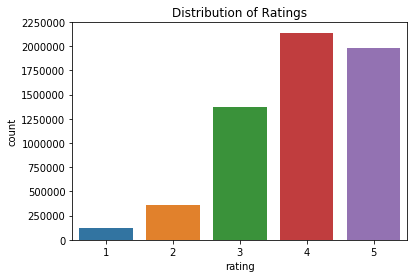

In [10]:
sns.countplot(ratings['rating']).set_title("Distribution of Ratings")

### What is the number of ratings per user (ideally should follow power law)

In [11]:
avg_ratings_user=ratings.groupby(['user_id'])['rating'].count().reset_index().rename(columns={'rating':'#Ratings'})


Text(0.5,1,'Average Number of Rating per user')

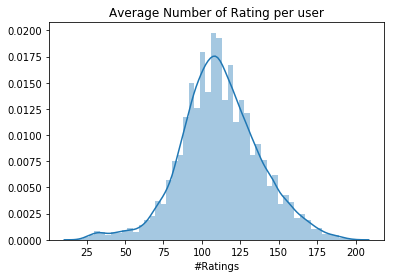

In [12]:
sns.distplot(avg_ratings_user['#Ratings']).set_title("Average Number of Rating per user")

### What are the top 10 highly rated books?

In [13]:
popular_books=books.sort_values(by='average_rating',ascending=False)[['book_id','average_rating','ratings_count','title']]

In [14]:
popular_books[:10]

,book_id,average_rating,ratings_count,title
3627,3628,4.82,28900,The Complete Calvin and Hobbes
3274,3275,4.77,33220,"Harry Potter Boxed Set, Books 1-5 (Harry Potter, #1-5)"
861,862,4.77,73572,"Words of Radiance (The Stormlight Archive, #2)"
8853,8854,4.76,9081,Mark of the Lion Trilogy
7946,7947,4.76,8953,ESV Study Bible
4482,4483,4.75,22351,It's a Magical World: A Calvin and Hobbes Collection
6360,6361,4.74,16766,There's Treasure Everywhere: A Calvin and Hobbes Collection
421,422,4.74,190050,"Harry Potter Boxset (Harry Potter, #1-7)"
3752,3753,4.73,24618,"Harry Potter Collection (Harry Potter, #1-6)"
6919,6920,4.73,14597,The Indispensable Calvin and Hobbes


Calvin and Hobbes and Harry Potter Box set seem to be the top 10 most highly rated books

### What books are most read??

In [15]:
most_read=books.sort_values(by='ratings_count',ascending=False)[['book_id','ratings_count','title']]


In [16]:
most_read[:10]

,book_id,ratings_count,title
0,1,4780653,"The Hunger Games (The Hunger Games, #1)"
1,2,4602479,"Harry Potter and the Sorcerer's Stone (Harry Potter, #1)"
2,3,3866839,"Twilight (Twilight, #1)"
3,4,3198671,To Kill a Mockingbird
4,5,2683664,The Great Gatsby
5,6,2346404,The Fault in Our Stars
6,7,2071616,The Hobbit
7,8,2044241,The Catcher in the Rye
9,10,2035490,Pride and Prejudice
8,9,2001311,"Angels & Demons (Robert Langdon, #1)"


A popularity based recommender can get list of  books, ordered by either ratings score or number of users who have rated.
The drawback of this model is that it is not personalised. 

The next approach can be to recommends books to users based on the content of the book - for example: if user A likes books that are related to history, we can recommend other history books.
Such kind of recommendation systems are called **Content Based Recommender Systems**

Before, we build content based recommender system, let us look at the other features available in the dataset

### Who are the most popular authors?

1. Author with most votes?
2. Author with highest ratings?

In [17]:
most_votes_author=books.groupby(['authors'])['ratings_count'].mean().reset_index().rename(columns={'ratings_count':'average_number_ratings'})
most_votes_author.sort_values(by='average_number_ratings',ascending=False)

,authors,average_number_ratings
274,"Anne Frank, Eleanor Roosevelt, B.M. Mooyaart-Doubleday",1.972666e+06
1522,"George Orwell, Erich Fromm, Celâl Üster",1.956832e+06
1870,"J.K. Rowling, Mary GrandPré, Rufus Beck",1.832823e+06
1869,"J.K. Rowling, Mary GrandPré",1.671596e+06
1652,Harper Lee,1.668670e+06
4581,"William Shakespeare, Robert Jackson",1.628519e+06
4553,William Golding,1.605019e+06
2542,Kathryn Stockett,1.531753e+06
352,Arthur Golden,1.300209e+06
737,"Charlotte Brontë, Michael Mason",1.198557e+06


There are books authored by more than one author.. 

 There seem to be non-english authors as well. This is because though good reads is english based it gives the author names of noth the translated edition and original edition.

### What factors effect a books rating??

In [18]:
factors=books[['average_rating','ratings_count','work_ratings_count','work_text_reviews_count','books_count','original_publication_year']]

In [19]:
corr=factors.corr()

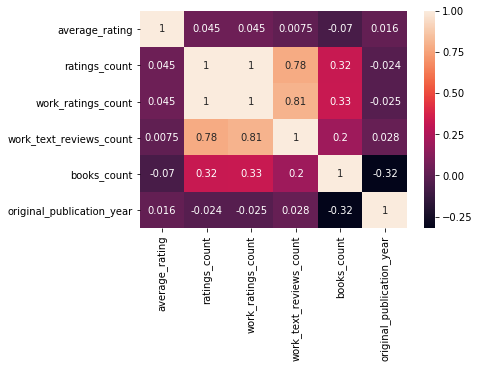

In [20]:
sns.heatmap(corr,annot=True)

There is only a very small correlation between average_rating and ratings_count

Each book may have many editions. goodreads_book_id and best_book_id generally point to the most popular edition of a given book, while goodreads work_id refers to the book in the abstract sense.

You can use the goodreads book and work IDs to create URLs to see the difference:

https://www.goodreads.com/book/show/2767052 https://www.goodreads.com/work/editions/2792775

Note that book_id in ratings.csv and to_read.csv maps to work_id, not to goodreads_book_id. It means that ratings for different editions are aggregated.

### Content Based Recommender System

In contenyt based recommender system, we use the properties of the items to recommend other similar items. In our case, we can use the tags associated with a book and the author information to build a contentbased recommender systems

To use the tags, we need to concatenate them as a book can be associated with multiple tags

In [21]:
book_tags=pd.merge(book_tags,tags,on='tag_id',how='left')
book_tags.head()

,goodreads_book_id,tag_id,count,tag_name
0,1,30574,167697,to-read
1,1,11305,37174,fantasy
2,1,11557,34173,favorites
3,1,8717,12986,currently-reading
4,1,33114,12716,young-adult


In [22]:
book_tags_final=book_tags.groupby(['goodreads_book_id'])['tag_name'].apply(" ".join).reset_index()
book_tags_final.head()

,goodreads_book_id,tag_name
0,1,to-read fantasy favorites currently-reading young-adult fiction harry-potter books-i-own owned ya series favourites magic childrens owned-books re-read adventure children j-k-rowling children-s sci-fi-fantasy childhood all-time-favorites default my-books classics reread i-own audiobook 5-stars children-s-books favorite-books kids novels fantasy-sci-fi favorite middle-grade audiobooks paranormal read-more-than-once my-library ya-fantasy teen witches english urban-fantasy british jk-rowling books read-in-2016 supernatural re-reads mystery ya-fiction harry-potter-series my-favorites own-it childrens-books library audio young-adult-fiction novel 2005 scifi-fantasy wizards faves favorite-series read-in-2015 made-me-cry juvenile shelfari-favorites kindle youth romance favourite to-buy read-in-2014 to-re-read all-time-favourites childhood-favorites kids-books ebook rereads contemporary read-in-english 5-star coming-of-age science-fiction-fantasy read-in-2017 england children-s-literature favourite-books on-my-shelf my-bookshelf children-s-lit bookshelf magical favs childhood-books potter
1,2,to-read currently-reading fantasy favorites children children-s all-time-favorites default fiction young-adult audiobook books-i-own novels kids owned fantasy-sci-fi harry-potter favorite paranormal my-library ya-fantasy teen witches urban-fantasy british jk-rowling re-reads supernatural ya-fiction childrens-books own-it ya mystery harry-potter-series my-favorites library novel audio young-adult-fiction wizards faves scifi-fantasy kindle favourites youth favorite-series shelfari-favorites juvenile favourite read-in-2014 childhood-favorites kids-books read-in-2017 owned-books coming-of-age science-fiction-fantasy all-time-favourites children-s-literature re-read england children-s-lit childhood-books potter fantasy-scifi 5-star magic favs hp classic 2003 magical boarding-school have audio-books action movie romance british-literature read-in-2013 fantasy-fiction rowling read-in-2011 read-multiple-times juvenile-fiction finished young-adult-fantasy read-again ya-books borrowed sci-fi fiction-fantasy childrens-lit audiobooks female-author fantasia children-young-adult books-i-have mine ya-lit middle-school
2,3,to-read favorites fantasy currently-reading young-adult fiction harry-potter books-i-own owned owned ya series favourites magic childrens re-read children adventure owned-books classics children-s childhood reread middle-grade j-k-rowling all-time-favorites sci-fi-fantasy children-s-books kids my-books audiobook favorite-books default novels 5-stars audiobooks i-own read-in-2016 favorite paranormal read-more-than-once fantasy-sci-fi re-reads my-library read-in-2015 books english ya-fantasy witches childrens-books british teen urban-fantasy mystery audio favorite-series supernatural my-favorites library read-in-2014 novel jk-rowling read-in-2017 ya-fiction faves own-it harry-potter-series juvenile kindle childhood-favorites wizards rereads kids-books scifi-fantasy re-reading read-in-english young-adult-fiction youth read-2016 children-s-literature classic favourite children-s-lit ebook to-re-read childhood-books contemporary friendship read-in-2013 shelfari-favorites on-my-shelf all-time-favourites favs to-buy science-fiction-fantasy read-2015 england bookshelf favourite-books my-bookshelf
3,5,favorites fantasy currently-reading young-adult to-read fiction harry-potter books-i-own owned ya favourites series magic childrens re-read adventure owned-books children j-k-rowling children-s childhood all-time-favorites sci-fi-fantasy middle-grade classics reread my-books default audiobook children-s-books favorite-books 5-stars kids i-own novels favorite audiobooks read-more-than-once fantasy-sci-fi paranormal read-in-2016 my-library ya-fantasy re-reads english witches urban-fantasy british books teen jk-rowling childrens-books read-in-2015 mystery supernatural audio shelfari-favorites my-favorites library faves time-tr

In [23]:
books_final=pd.merge(books,book_tags_final,on='goodreads_book_id',how='left')
books_final

,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url,tag_name
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m/2767052.jpg,https://images.gr-assets.com/books/1447303603s/2767052.jpg,favorites currently-reading young-adult fiction dystopian to-read dystopia fantasy ya science-fiction books-i-own sci-fi series owned favourites romance adventure hunger-games book-club kindle teen read-in-2012 post-apocalyptic my-books the-hunger-games favorite-books action suzanne-collins re-read all-time-favorites ya-fiction survival sci-fi-fantasy books favorite scifi 5-stars i-own read-in-2011 novels ebook audiobook young-adult-fiction thriller my-favorites audiobooks read-2012 futuristic ebooks default library fantasy-sci-fi suspense shelfari-favorites faves reread read-in-2010 my-library audio favorite-series teen-fiction ya-lit ya-books own-it finished action-adventure love love-triangle favs loved distopia read-in-2013 coming-of-age dystopian-fiction distopian borrowed english to-buy novel read-more-than-once favourite read-2011 favourite-books scifi-fantasy ya-fantasy future read-in-2014 contemporary trilogy dystopias e-book reviewed ya-dystopian speculative-fiction 2012-reads finished-series sf completed-series drama 5-star
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,...,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m/3.jpg,https://images.gr-assets.com/books/1474154022s/3.jpg,to-read favorites fantasy currently-reading young-adult fiction harry-potter books-i-own owned owned ya series favourites magic childrens re-read children adventure owned-books classics children-s childhood reread middle-grade j-k-rowling all-time-favorites sci-fi-fantasy children-s-books kids my-books audiobook favorite-books default novels 5-stars audiobooks i-own read-in-2016 favorite paranormal read-more-than-once fantasy-sci-fi re-reads my-library read-in-2015 books english ya-fantasy witches childrens-books british teen urban-fantasy mystery audio favorite-series supernatural my-favorites library read-in-2014 novel jk-rowling read-in-2017 ya-fiction faves own-it harry-potter-series juvenile kindle childhood-favorites wizards rereads kids-books scifi-fantasy re-reading read-in-english young-adult-fiction youth read-2016 children-s-literature classic favourite children-s-lit ebook to-re-read childhood-books contemporary friendship read-in-2013 shelfari-favorites on-my-shelf all-time-favourites favs to-buy science-fiction-fantasy read-2015 england bookshelf favourite-books my-bookshelf
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,...,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m/41865.jpg,https://images.gr-assets.com/books/1361039443s/41865.jpg,young-adult fantasy favorites vampires ya fiction to-read paranormal books-i-own vampire twilight paranormal-romance supernatural teen urban-fantasy owned-books stephenie-meyer my-books favourites werewolves i-own chick-lit re-read ya-fiction twilight-saga default young-adult-fiction sci-fi-fantasy contemporary twilight-series books love ya-fantasy horror book-club my-library novels favorite favorite-books teen-fiction guilty-pleasures high-school read-more-than-once fantasy-sci-fi stephanie-meyer vamps own-it ya-books my-favorites shelfari-favorites library audiobook kindle finished all-time-favorites read-in-2009 love-triangle 5-stars vampire-books read-in-2008 reread ya-lit abandoned never-again movies audiobooks science-fiction finished-series ya-paranormal guilty-pleasure cu

### There are 34252 tags overall in the dataset, to build a simple Content Based Filtering system, we can build a TF-IDF Model and then calculate the cosine similarity

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

In [25]:
def getSimilarityMatrix(data,ngram_range=(1,2),min_df=0):
    tf=TfidfVectorizer(analyzer='word',ngram_range=ngram_range)
    tfidf_matrix=tf.fit_transform(data)
    cosine_sim=linear_kernel(tfidf_matrix,tfidf_matrix)
    return cosine_sim

In [26]:
tag_similarity_matrix=getSimilarityMatrix(books_final['tag_name'])
tag_similarity_matrix

array([[1.        , 0.17127899, 0.1632564 , ..., 0.04547493, 0.06177077,
        0.01666192],
       [0.17127899, 1.        , 0.17424248, ..., 0.04702583, 0.06293497,
        0.02201723],
       [0.1632564 , 0.17424248, 1.        , ..., 0.02876147, 0.03575429,
        0.01907293],
       ...,
       [0.04547493, 0.04702583, 0.02876147, ..., 1.        , 0.02642018,
        0.07305185],
       [0.06177077, 0.06293497, 0.03575429, ..., 0.02642018, 1.        ,
        0.06633839],
       [0.01666192, 0.02201723, 0.01907293, ..., 0.07305185, 0.06633839,
        1.        ]])

In [27]:
def getMostSimilarBooks(similarity_matrix,title,n=10):
    titles = books_final['title']
    indices = pd.Series(books_final.index, index=books['title'])
    idx = indices[title]
    sim_scores = list(enumerate(similarity_matrix[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:n+1]
    book_indices = [i[0] for i in sim_scores]
    return titles.iloc[book_indices]

In [28]:
getMostSimilarBooks(similarity_matrix=tag_similarity_matrix,title="The Hobbit")

188     The Lord of the Rings (The Lord of the Rings, #1-3)                  
154     The Two Towers (The Lord of the Rings, #2)                           
160     The Return of the King (The Lord of the Rings, #3)                   
18      The Fellowship of the Ring (The Lord of the Rings, #1)               
610     The Silmarillion (Middle-Earth Universe)                             
4975    Unfinished Tales of Númenor and Middle-Earth                         
2308    The Children of Húrin                                                
465     The Hobbit: Graphic Novel                                            
8271    The Complete Guide to Middle-Earth                                   
963     J.R.R. Tolkien 4-Book Boxed Set: The Hobbit and The Lord of the Rings
Name: title, dtype: object

In [29]:
getMostSimilarBooks(similarity_matrix=tag_similarity_matrix,title="The Complete Calvin and Hobbes")

5579    The Calvin and Hobbes Lazy Sunday Book                           
1787    The Calvin and Hobbes Tenth Anniversary Book                     
6919    The Indispensable Calvin and Hobbes                              
1009    The Essential Calvin and Hobbes: A Calvin and Hobbes Treasury    
6589    The Authoritative Calvin and Hobbes: A Calvin and Hobbes Treasury
7253    Homicidal Psycho Jungle Cat: A Calvin and Hobbes Collection      
5206    The Days Are Just Packed: A Calvin and Hobbes Collection         
8977    The Revenge of the Baby-Sat                                      
4482    It's a Magical World: A Calvin and Hobbes Collection             
6360    There's Treasure Everywhere: A Calvin and Hobbes Collection      
Name: title, dtype: object

We can see this had done really well. But, is this good enough?? 

this model will only recommend book similar to what he had read. he will not see books of different genres .

To solve this, we use Collabrative Filtering

### Collabrative Filtering

This model is based on the fact that similar users will like similar items.

In [45]:
ratings=pd.merge(ratings,books[['title','book_id']],on='book_id',how='left')

import turicreate
ratings_data = turicreate.SFrame(ratings)


In [47]:
ratings_data.shape

(5976479, 4)

In [48]:
ratings.head()

,user_id,book_id,rating,title
0,1,258,5,"The Shadow of the Wind (The Cemetery of Forgotten Books, #1)"
1,2,4081,4,I am Charlotte Simmons
2,2,260,5,How to Win Friends and Influence People
3,2,9296,5,The Drama of the Gifted Child: The Search for the True Self
4,2,2318,3,The Millionaire Next Door: The Surprising Secrets of Americas Wealthy


#### Split the data into training and validation set

In [49]:
training_data, validation_data = turicreate.recommender.util.random_split_by_user(ratings_data, 'user_id', 'book_id',item_test_proportion=0.25)

In [50]:
training_data.shape

(5948715, 4)

In [51]:
validation_data.shape

(27764, 4)

Let us first not use ratings, and only use whther a user read a book or not and build a item-item recommender.
In turicreate, by deafult if no target field (implicit feedback) is not provided, it defaults to item-item recommender

In [52]:
model = turicreate.recommender.create(training_data, 'user_id', 'book_id')


Warning: Ignoring columns rating, title;

To use one of these as a target column, set target = <column_name>

and use a method that allows the use of a target.

Preparing data set.

Data has 5948715 observations with 53424 users and 10000 items.

Data prepared in: 2.37849s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 17.831ms                       | 1.75       |

| 167.765ms                      | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 595.16ms                            | 0                | 0               |

| 3.60s                               | 62.25            | 6237            |

| 5.96s                               | 100              | 10000           |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 6.15867s


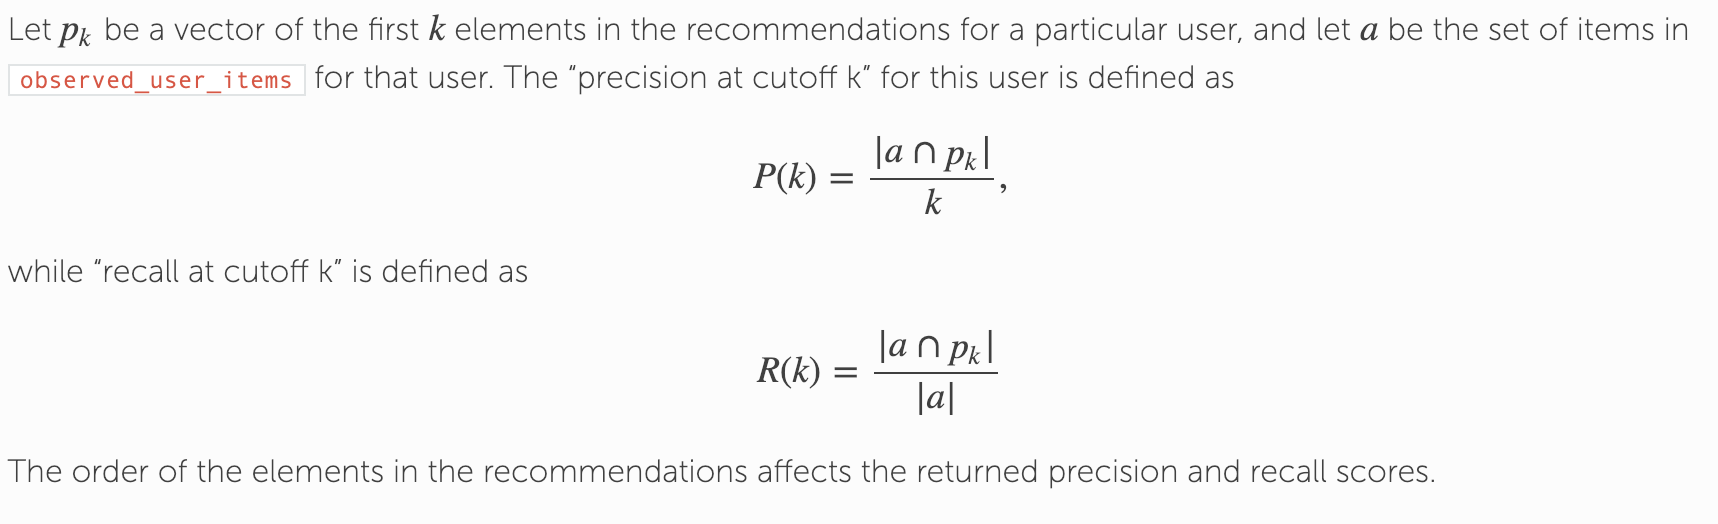


In [115]:
model.evaluate(validation_data)

recommendations finished on 1000/1000 queries. users per second: 2614.24


Precision and recall summary statistics by cutoff
+--------+---------------------+----------------------+
| cutoff |    mean_precision   |     mean_recall      |
+--------+---------------------+----------------------+
|   1    |  0.5819999999999997 | 0.022719688156076837 |
|   2    |  0.5299999999999996 | 0.04083673435247345  |
|   3    |  0.4956666666666664 | 0.05747796162813136  |
|   4    |  0.4605000000000007 | 0.07060659731498146  |
|   5    |  0.4307999999999995 |  0.0827923044256554  |
|   6    | 0.41233333333333305 | 0.09499148182811147  |
|   7    |  0.3922857142857146 | 0.10502979187743701  |
|   8    | 0.37662499999999954 | 0.11515655919550755  |
|   9    | 0.36055555555555563 | 0.12355065524496787  |
|   10   |  0.3475999999999998 | 0.13199841539004104  |
+--------+---------------------+----------------------+
[10 rows x 3 columns]



{'precision_recall_by_user': Columns:
 	user_id	int
 	cutoff	int
 	precision	float
 	recall	float
 	count	int
 
 Rows: 18000
 
 Data:
 +---------+--------+--------------------+----------------------+-------+
 | user_id | cutoff |     precision      |        recall        | count |
 +---------+--------+--------------------+----------------------+-------+
 |    55   |   1    |        0.0         |         0.0          |   21  |
 |    55   |   2    |        0.0         |         0.0          |   21  |
 |    55   |   3    | 0.3333333333333333 | 0.047619047619047616 |   21  |
 |    55   |   4    |        0.25        | 0.047619047619047616 |   21  |
 |    55   |   5    |        0.2         | 0.047619047619047616 |   21  |
 |    55   |   6    | 0.3333333333333333 | 0.09523809523809523  |   21  |
 |    55   |   7    | 0.2857142857142857 | 0.09523809523809523  |   21  |
 |    55   |   8    |       0.375        | 0.14285714285714285  |   21  |
 |    55   |   9    | 0.3333333333333333 | 0.1428571

In [59]:
user_1=ratings[ratings['user_id']==55]

In [68]:
top_20_user=model.recommend(users=[55],k=10)

In [70]:
valid_user=validation_data.filter_by(55,'user_id')

In [71]:
final_user=top_20_user.join(valid_user,on='book_id',how='left')

In [72]:
final_user

user_id,book_id,score,rank,user_id.1,rating,title
55,11,0.054220174843410275,3,55,4,The Kite Runner
55,26,0.04565362829082417,9,None,None,None
55,14,0.04720570793691671,7,None,None,None
55,46,0.05117528056198696,5,None,None,None
55,22,0.053062790407324735,4,None,None,None
55,33,0.054653500048619394,2,None,None,None
55,45,0.06324077271065622,1,None,None,None
55,21,0.04560177393679349,10,55,3,Harry Potter and theOrder of the Phoenix ...
55,24,0.0466096727353222,8,55,3,Harry Potter and theGoblet of Fire (Harry ...
55,2,0.04786305157643444,6,55,3,Harry Potter and theSorcerer's Stone (Harry ...


### Let us also look at books which are similar based on this

In [93]:
book_id=books.loc[books['title']=='The Complete Calvin and Hobbes','book_id'].tolist()

similar_items=model.get_similar_items(book_id,k=10)

In [94]:
similar_items

book_id,similar,score,rank
3628,1788,0.15306121110916138,1
3628,1010,0.10102301836013794,2
3628,5207,0.09836065769195557,3
3628,780,0.09607499837875366,4
3628,4483,0.08964645862579346,5
3628,5580,0.08248913288116455,6
3628,4046,0.07861274480819702,7
3628,6361,0.07670044898986816,8
3628,6590,0.06794685125350952,9
3628,8978,0.054574668407440186,10


In [91]:
book_title=ratings_data[['book_id','title']]

In [92]:
book_title

book_id,title
258,The Shadow of the Wind(The Cemetery of ...
4081,I am Charlotte Simmons
260,How to Win Friends andInfluence People ...
9296,The Drama of the GiftedChild: The Search for ...
2318,The Millionaire NextDoor: The Surprising ...
26,"The Da Vinci Code (RobertLangdon, #2) ..."
315,Who Moved My Cheese?
33,Memoirs of a Geisha
301,Heart of Darkness
2686,Blue Ocean Strategy: HowTo Create Uncontested ...


In [95]:
similar_items=similar_items.join(book_title,on={'similar':'book_id'},how='left')

In [96]:
similar_items

book_id,similar,score,rank,title
3628,1010,0.10102301836013794,2,The Essential Calvin andHobbes: A Calvin and ...
3628,5207,0.09836065769195557,3,The Days Are Just Packed:A Calvin and Hobbes ...
3628,1788,0.15306121110916138,1,The Calvin and HobbesTenth Anniversary Book ...
3628,4483,0.08964645862579346,5,It's a Magical World: ACalvin and Hobbes ...
3628,6590,0.06794685125350952,9,The Authoritative Calvinand Hobbes: A Calvin and ...
3628,6361,0.07670044898986816,8,There's TreasureEverywhere: A Calvin and ...
3628,1010,0.10102301836013794,2,The Essential Calvin andHobbes: A Calvin and ...
3628,6361,0.07670044898986816,8,There's TreasureEverywhere: A Calvin and ...
3628,4483,0.08964645862579346,5,It's a Magical World: ACalvin and Hobbes ...
3628,5207,0.09836065769195557,3,The Days Are Just Packed:A Calvin and Hobbes ...


Even though we never explicitly gave the name od the book the model has identified all Calvin Hbbes books as highly similar

### Let us build a Recommender System considering the Ratings 

In [111]:
model_2 = turicreate.item_similarity_recommender.create(training_data, 'user_id', 'book_id',target='rating')


Warning: Ignoring columns title;

To use these columns in scoring predictions, use a model that allows the use of additional features.

Preparing data set.

Data has 5948715 observations with 53424 users and 10000 items.

Data prepared in: 3.65205s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 10.242ms                       | 1.75       |

| 203.926ms                      | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 624.526ms                           | 0                | 0               |

| 3.63s                               | 55               | 5515            |

| 7.12s                               | 100              | 10000           |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 7.38451s

In [112]:
model_2.evaluate_rmse(validation_data,target='rating')

{'rmse_by_user': Columns:
 	user_id	int
 	rmse	float
 	count	int
 
 Rows: 1000
 
 Data:
 +---------+--------------------+-------+
 | user_id |        rmse        | count |
 +---------+--------------------+-------+
 |   5783  | 3.847660473041364  |   31  |
 |  33316  | 4.196178041163094  |   30  |
 |  45930  | 3.1676255031741176 |   29  |
 |  22772  |  3.43103601838131  |   26  |
 |  13518  | 3.6705261822344855 |   35  |
 |  11581  | 2.9129825633707007 |   16  |
 |  23577  | 3.431405757041383  |   37  |
 |  15913  | 4.008257267557576  |   26  |
 |  15504  | 4.040906357878154  |   23  |
 |  24375  | 4.4895936624843324 |   25  |
 +---------+--------------------+-------+
 [1000 rows x 3 columns]
 Note: Only the head of the SFrame is printed.
 You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns.,
 'rmse_by_item': Columns:
 	book_id	int
 	rmse	float
 	count	int
 
 Rows: 6954
 
 Data:
 +---------+--------------------+-------+
 | book_id |        rmse        | coun

In [113]:
model_2.evaluate_rmse(training_data,target='rating')

{'rmse_by_user': Columns:
 	user_id	int
 	rmse	float
 	count	int
 
 Rows: 53424
 
 Data:
 +---------+--------------------+-------+
 | user_id |        rmse        | count |
 +---------+--------------------+-------+
 |  21855  | 4.430621960273091  |  136  |
 |   7899  | 4.415498955760625  |   99  |
 |  25263  | 4.273005078841926  |  102  |
 |  30621  | 4.136906735781155  |   90  |
 |  43116  | 3.8802839887462057 |  116  |
 |  27112  | 4.190335132319076  |  132  |
 |  26319  | 4.740158753179054  |  110  |
 |  26439  | 4.911642548242507  |  125  |
 |   5288  | 3.2138423187972136 |  106  |
 |  19584  | 4.300155621261543  |  129  |
 +---------+--------------------+-------+
 [53424 rows x 3 columns]
 Note: Only the head of the SFrame is printed.
 You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns.,
 'rmse_by_item': Columns:
 	book_id	int
 	rmse	float
 	count	int
 
 Rows: 10000
 
 Data:
 +---------+--------------------+-------+
 | book_id |        rmse        | c

In [117]:
model_2.evaluate_precision_recall(validation_data)

recommendations finished on 1000/1000 queries. users per second: 2788.86

{'precision_recall_by_user': Columns:
 	user_id	int
 	cutoff	int
 	precision	float
 	recall	float
 	count	int
 
 Rows: 18000
 
 Data:
 +---------+--------+---------------------+----------------------+-------+
 | user_id | cutoff |      precision      |        recall        | count |
 +---------+--------+---------------------+----------------------+-------+
 |    55   |   1    |         0.0         |         0.0          |   21  |
 |    55   |   2    |         0.0         |         0.0          |   21  |
 |    55   |   3    |  0.3333333333333333 | 0.047619047619047616 |   21  |
 |    55   |   4    |         0.25        | 0.047619047619047616 |   21  |
 |    55   |   5    |         0.2         | 0.047619047619047616 |   21  |
 |    55   |   6    |  0.3333333333333333 | 0.09523809523809523  |   21  |
 |    55   |   7    | 0.42857142857142855 | 0.14285714285714285  |   21  |
 |    55   |   8    |         0.5         | 0.19047619047619047  |   21  |
 |    55   |   9    |  0.4444444444444444

In [116]:
model_3 = turicreate.factorization_recommender.create(training_data, 'user_id', 'book_id',target='rating')


Preparing data set.

Data has 5948715 observations with 53424 users and 10000 items.

Data prepared in: 7.46091s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 8        |

| regularization                 | L2 Regularization on Factors                     | 1e-08    |

| solver                         | Solver used for training                         | adagrad  |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 743589 / 5948715 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 16.6667           | Not Viable                               |

| 1       | 4.16667           | Not Viable                               |

| 2       | 1.04167           | Not Viable                               |

| 3       | 0.260417          | 0.289623                                 |

| 4       | 0.130208          | 0.298589                                 |

| 5       | 0.0651042         | 0.410134                                 |

| 6       | 0.0325521         | 0.586569                                 |

+---------+-------------------+------------------------------------------+

| Final   | 0.260417          | 0.289623                                 |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 90us         | 0.98228           | 0.991101              |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 1.32s        | 0.787514          | 0.887055              | 0.260417    |

| 2       | 2.58s        | 0.663764          | 0.81433               | 0.260417    |

| 3       | 3.95s        | 0.624782          | 0.790016              | 0.260417    |

| 4       | 5.58s        | 0.605361          | 0.77761               | 0.260417    |

| 5       | 7.39s        | 0.593811          | 0.770132              | 0.260417    |

| 10      | 14.12s       | 0.568662          | 0.753585              | 0.260417    |

| 15      | 20.44s       | 0.559021          | 0.747141              | 0.260417    |

| 20      | 27.75s       | 0.553473          | 0.743408              | 0.260417    |

| 25      | 34.60s       | 0.550132          | 0.741151              | 0.260417    |

| 30      | 41.03s       | 0.547513          | 0.739376              | 0.260417    |

| 35      | 47.22s       | 0.545426          | 0.73796               | 0.260417    |

| 40      | 53.50s       | 0.543975          | 0.736973              | 0.260417    |

| 45      | 1m 0s        | 0.542639          | 0.736063              | 0.260417    |

| 50      | 1m 6s        | 0.541483          | 0.735275              | 0.260417    |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.528986

Final training RMSE: 0.726728

Factorization recommender has a much much lower RMSE than item similarity recommender

In [118]:
model_3.evaluate_rmse(validation_data,target='rating')

{'rmse_by_user': Columns:
 	user_id	int
 	rmse	float
 	count	int
 
 Rows: 1000
 
 Data:
 +---------+--------------------+-------+
 | user_id |        rmse        | count |
 +---------+--------------------+-------+
 |   5783  | 0.9056421204844872 |   31  |
 |  33316  | 0.8331003204595658 |   30  |
 |  45930  | 0.5490743722501252 |   29  |
 |  22772  | 0.9436293498864293 |   26  |
 |  13518  | 0.9620374475882048 |   35  |
 |  11581  | 0.9273638068012636 |   16  |
 |  23577  | 0.9345809488225041 |   37  |
 |  15913  | 0.8551349647883705 |   26  |
 |  15504  | 0.7920466267429852 |   23  |
 |  24375  | 0.8002423952206067 |   25  |
 +---------+--------------------+-------+
 [1000 rows x 3 columns]
 Note: Only the head of the SFrame is printed.
 You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns.,
 'rmse_by_item': Columns:
 	book_id	int
 	rmse	float
 	count	int
 
 Rows: 6954
 
 Data:
 +---------+---------------------+-------+
 | book_id |         rmse        | co